# Импорт библиотек

In [ ]:
! pip install datasets==2.15.0

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from transformers import ViTForImageClassification
from transformers import ViTConfig, ViTForImageClassification
from datasets import load_dataset
from datasets import Dataset
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
import torch.optim as optim
from torchvision import models, transforms, datasets
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models.densenet import DenseNet121_Weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DF = pd.read_excel('/content/data_8_30160.xlsx')
DF['id'] = DF['id'].fillna('').astype(str)
DF.to_excel('data_8_new.xlsx',  index=False)

# Загрузка данных

In [ ]:

data = pd.read_excel("/content/data_8_new.xlsx")
data= Dataset.from_pandas(data)
data

Dataset({
    features: ['id', 'IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH'],
    num_rows: 3169
})

# Распределение по классам биомаркеров

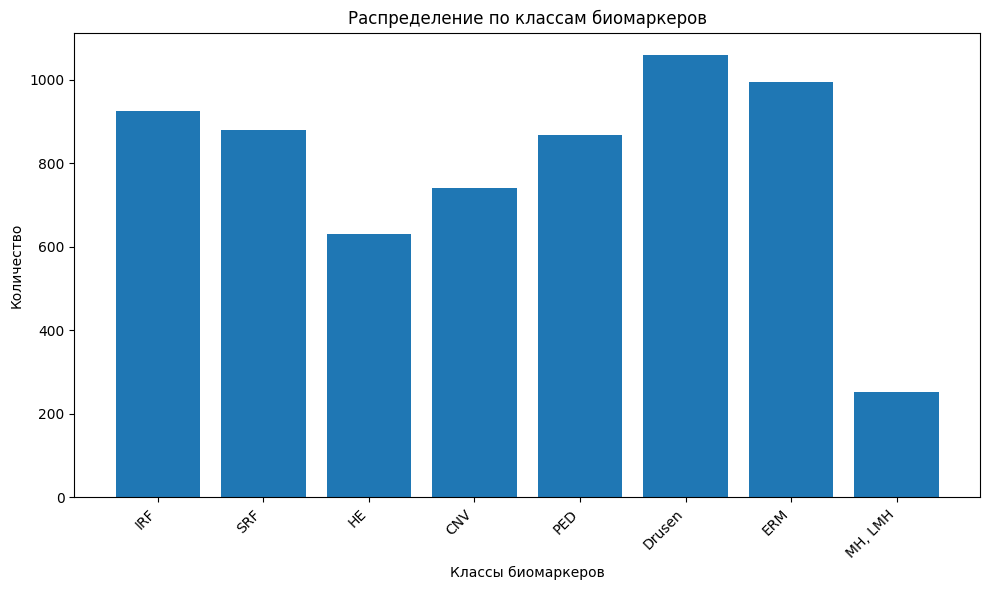

In [ ]:
dataset_no_id = data.remove_columns(["id"]) # Создаем новый Dataset без 'id'

labels = ['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']
def plot_histogram(data_split):
        if not isinstance(data_split, Dataset):
            raise TypeError("data_split must be a Dataset object.")

        class_counts = {
            label: 0 for label in labels
        }

        for i in range(len(data_split)):
            sample = data_split[i]

            for label in labels:
                try:
                    class_counts[label] += sample[label]
                except KeyError as e:
                    print(f"KeyError: {e}. Обратите внимание на структуру данных.")
                    return

        classes = list(class_counts.keys())
        counts = list(class_counts.values())

        plt.figure(figsize=(10, 6))
        plt.bar(classes, counts)
        plt.xlabel('Классы биомаркеров')
        plt.ylabel('Количество')
        plt.title('Распределение по классам биомаркеров')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

plot_histogram(dataset_no_id)


# Совместное рапределение биомаркеров

In [ ]:
from collections import defaultdict
def plot_combined_biomarkers(data_split):
    biomarkers_pairs = defaultdict(int)

    for entry in data_split:
        biomarkers = {key: value for key, value in entry.items() if key in labels}
        active_biomarkers = [biomarkers for biomarkers, value in biomarkers.items() if value > 0]

        for pair in itertools.combinations(sorted(active_biomarkers), 2):
            biomarkers_pairs[pair] += 1

    sorted_pairs = sorted(biomarkers_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(18, 6))
    plt.bar(pairs[:20], counts[:20])
    plt.xlabel('Пары биомаркеров')
    plt.ylabel('Количество')
    plt.title('Совместное появление биомаркеров')
    plt.xticks(rotation=45)

    plt.show()


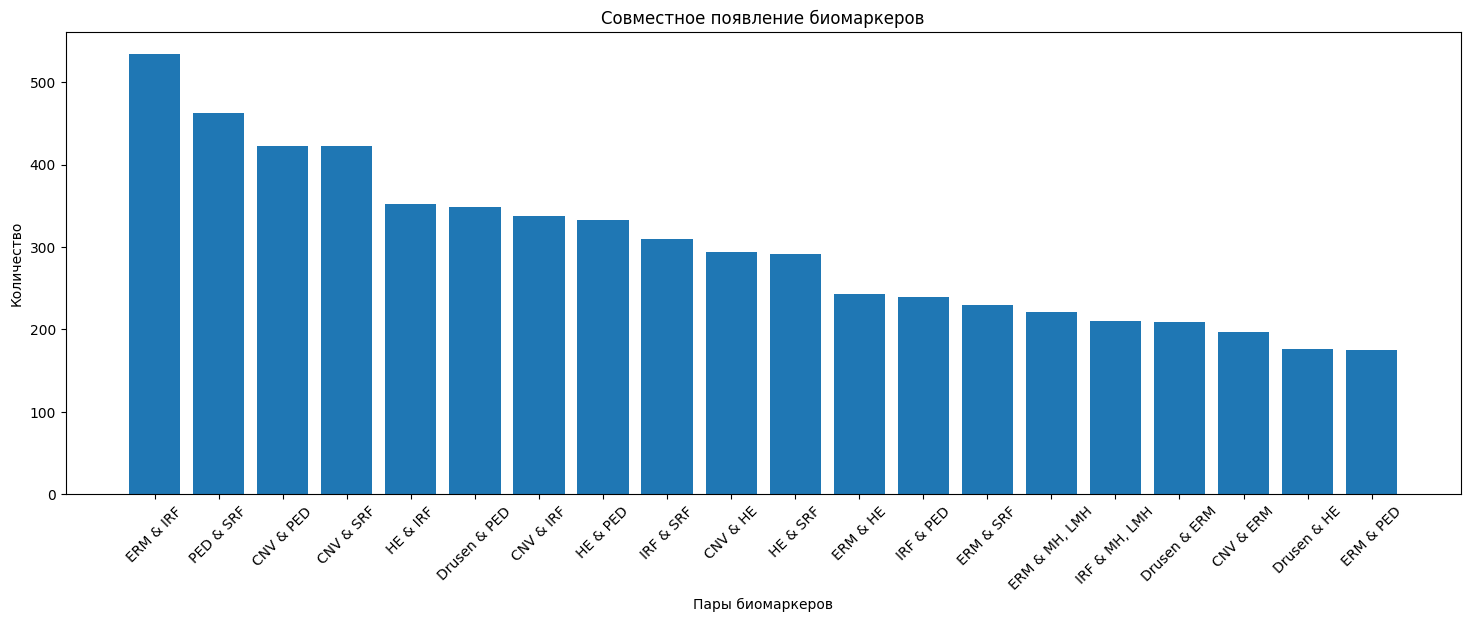

In [ ]:
plot_combined_biomarkers(dataset_no_id)

  # Предварительная обработка данных

In [ ]:
class CustomDataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = list(range(len(dataset)))
        if shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i >= len(self.indices):
            raise StopIteration

        batch_indices = self.indices[self.i:self.i + self.batch_size]
        self.i += self.batch_size

        batch = [self.dataset[idx] for idx in batch_indices]

        images = [item[0] for item in batch]
        labels = [item[1] for item in batch]


        images = torch.stack(images)
        labels = torch.stack(labels)

        return images, labels, #img_name

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

In [ ]:
class OCTDataset(Dataset):
    def __init__(self, images_dir, labels_file, transform=None):
        """
        Args:
            images_dir (string): Directory with all the images.
            labels_file (string): Path to the XLSX file with labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_dir = images_dir
        self.labels_df = pd.read_excel(labels_file)
        self.labels_df['id'] = self.labels_df['id'].astype(str)
        self.transform = transform
        self.valid_indices = self._find_valid_indices() # Find valid indices

    def _find_valid_indices(self):
        """
        Find indices for which image files exist
        """
        valid_indices = []
        for idx in range(len(self.labels_df)):
            img_name = os.path.join(self.images_dir, f"{self.labels_df['id'].iloc[idx]}.jpg")
            if os.path.exists(img_name):
                valid_indices.append(idx)
        return valid_indices


    def __len__(self):
        return len(self.valid_indices) # Return length of valid indices

    def __getitem__(self, idx):
        # idx is a single integer
        real_idx = self.valid_indices[idx]
        img_name = os.path.join(self.images_dir, f"{self.labels_df['id'].iloc[real_idx]}.jpg")

        try:
            image = Image.open(img_name).convert('RGB')
        except FileNotFoundError:
            print(f"Error: File not found at {img_name}")
            # Handle missing images: create a black image and zero label.
            image = Image.new('RGB', (224, 224), color='black') # Black image
            labels = torch.zeros(12, dtype=torch.float32) # Zero label
            if self.transform:
                image = self.transform(image)
            return image, labels

        labels = torch.tensor(self.labels_df[['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']].iloc[real_idx].values, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, labels, img_name

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize(180),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet stats
])

In [ ]:
data_transforms_train = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomRotation(15),  #  вращения
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    transforms.ToTensor(),
    #transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    #transforms.Lambda(lambda x: add_gaussian_noise(x, mean=0., std=0.01)),
    transforms.CenterCrop(224),

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet stats
])

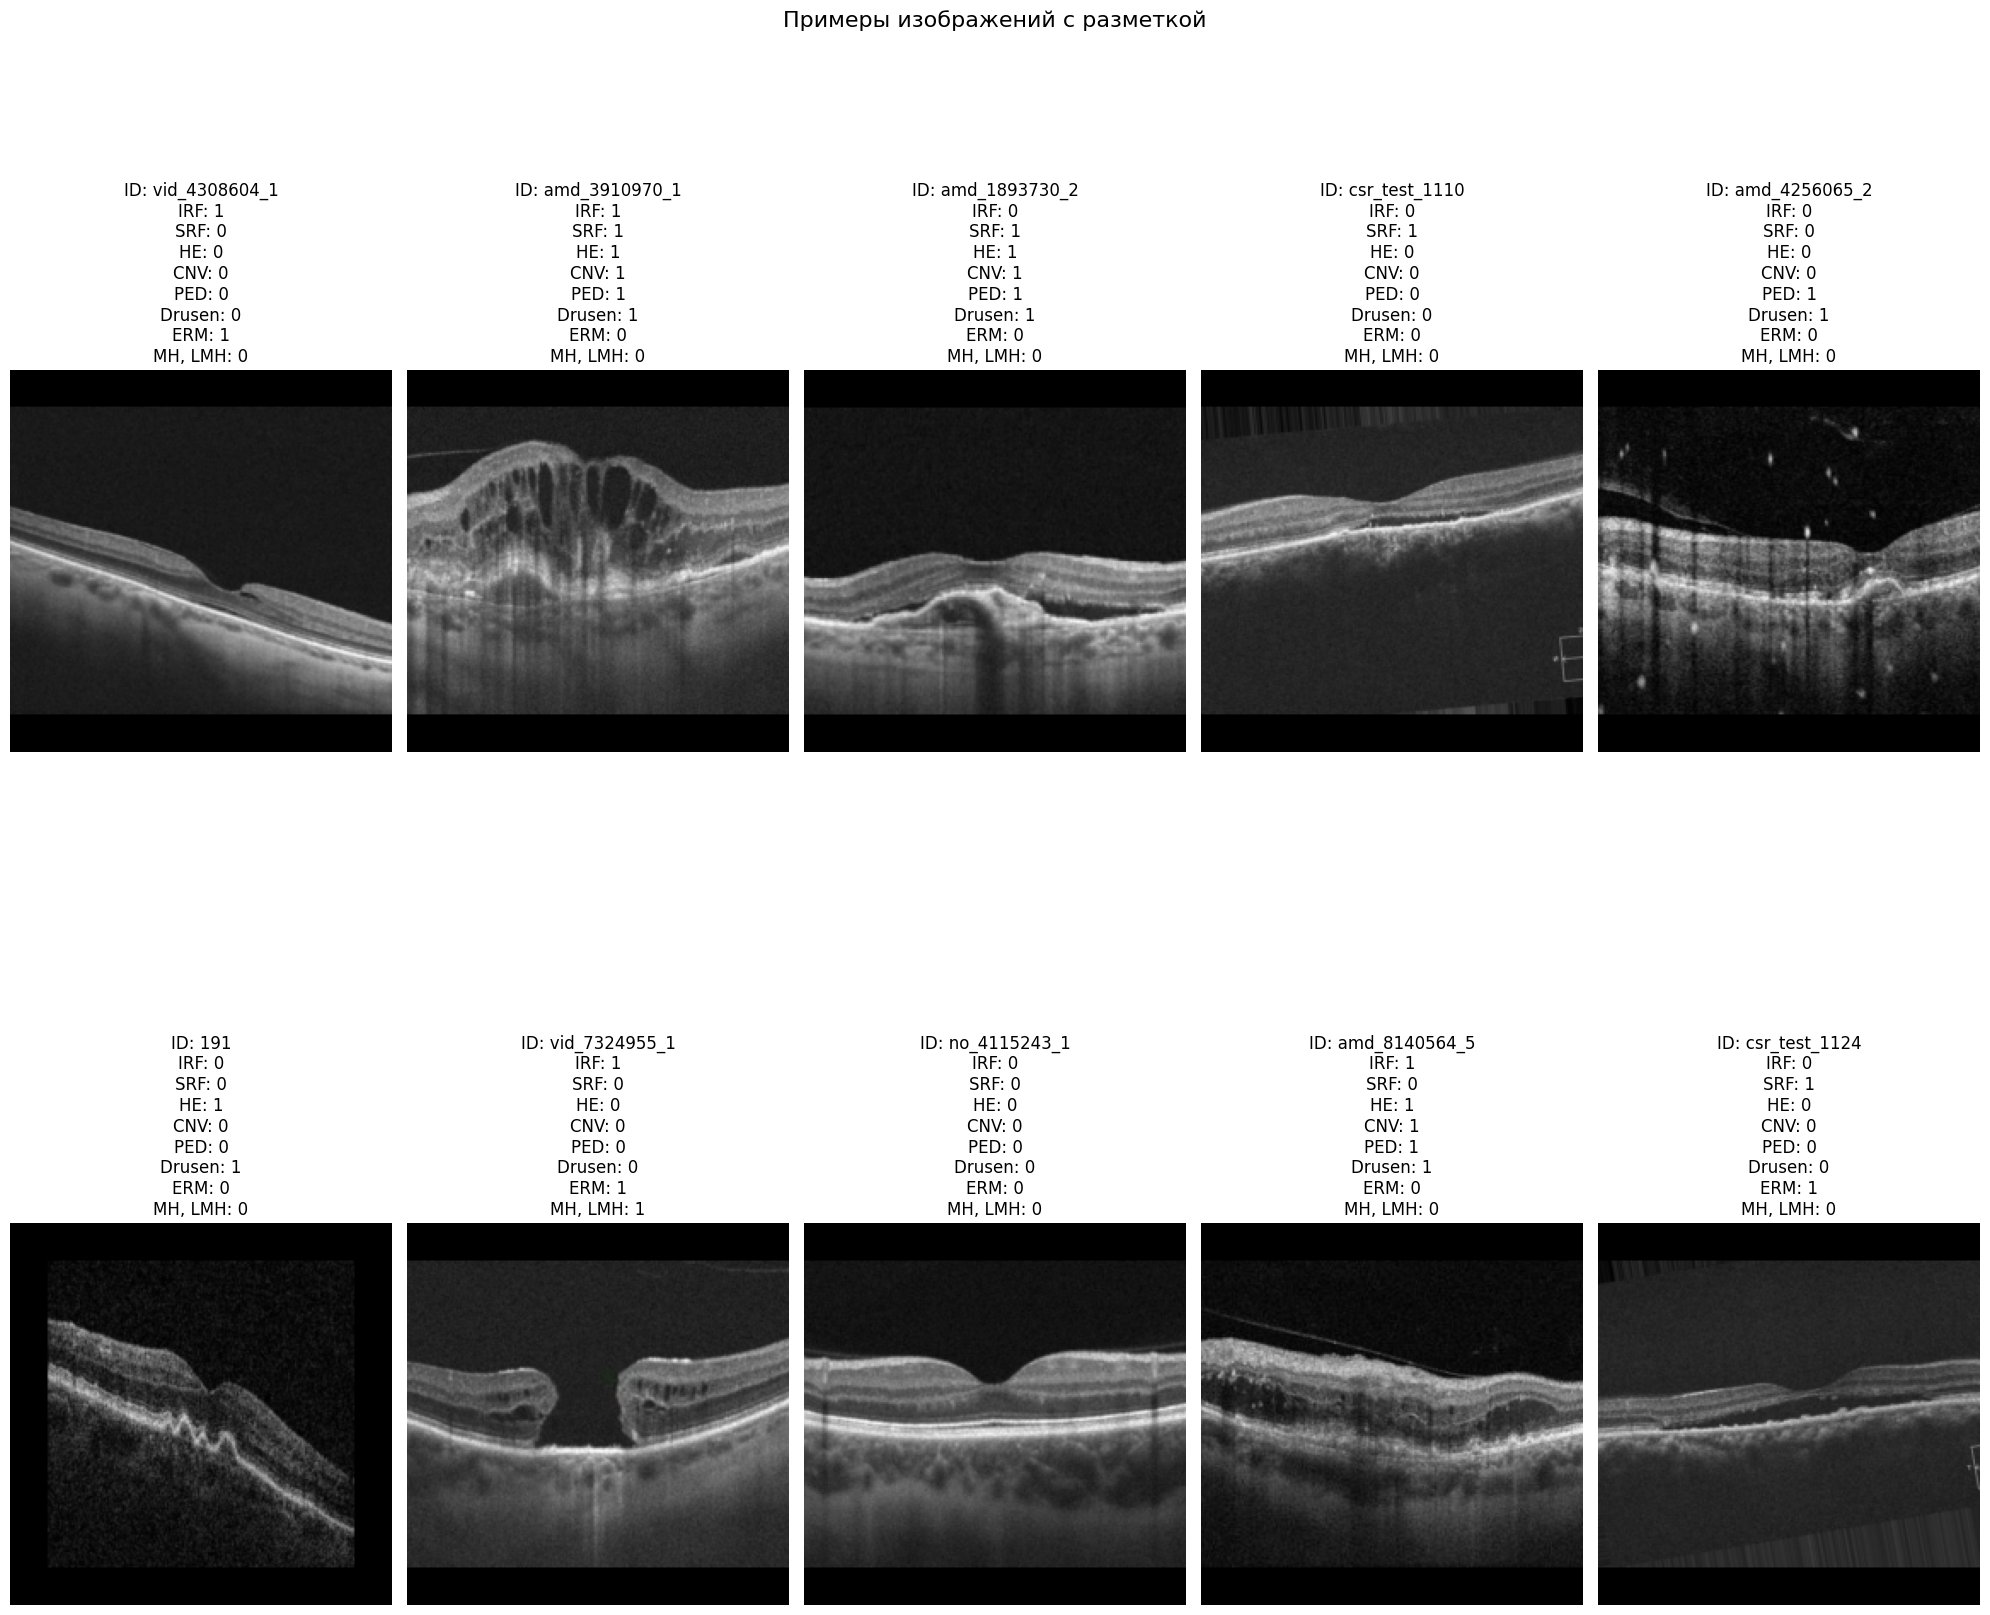

In [ ]:
# Создаем датасет
dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=data_transforms
)
# 10 случайных индексов
indices = torch.randperm(len(dataset))[:10]


def denormalize(image):
    """Денормализует изображение для отображения"""
    if isinstance(image, torch.Tensor):
        image = image.numpy()

    # Транспонируем
    image = image.transpose(1, 2, 0)

    #  нормализация ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    image = std * image + mean  # Денормализация
    image = np.clip(image, 0, 1)  # Ограничиваем значения [0, 1]
    return image


fig, axes = plt.subplots(2, 5, figsize=(20, 20))
fig.suptitle('Примеры изображений с разметкой', fontsize=16)

for i, idx in enumerate(indices):
    image, label, name = dataset[idx]


    image = denormalize(image)

    label_names = ['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']
    label_text = '\n'.join([f'{n}: {v:.0f}' for n, v in zip(label_names, label.numpy())])

    ax = axes[i//5, i%5]
    ax.imshow(image)
    ax.set_title(f"ID: {dataset.labels_df['id'].iloc[dataset.valid_indices[idx]]}\n{label_text}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# индексы для разделения
dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=None  # Временно None
)

train_size = 0.9
test_size = 0.1

train_idx, test_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=test_size,
    train_size=train_size,
    random_state=42
)

#  отдельные датасеты с разными трансформациями
train_dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=data_transforms_train
)
train_dataset = Subset(train_dataset, train_idx)

test_dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=data_transforms
)
test_dataset = Subset(test_dataset, test_idx)


print(f"Размер тренировочного набора: {len(train_dataset)}")
print(f"Размер тестового набора: {len(test_dataset)}")


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



Размер тренировочного набора: 2821
Размер тестового набора: 314


In [ ]:
# Create CUSTOM data loaders
train_dataloader = CustomDataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True)

test_dataloader = CustomDataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False)

#Обучение модели.

## Загрузка весов модели

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models.densenet import DenseNet121_Weights

# 1. Инициализация DenseNet121 с предобученными весами
model = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)

# 2. Заморозка всех слоев, кроме последнего блока
for name, param in model.named_parameters():
    if 'features.denseblock4' not in name and 'classifier' not in name:
        param.requires_grad = False

# 3. Модификация классификатора с добавлением Dropout и BatchNorm
num_classes = 8
num_features = model.classifier.in_features

model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 147MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Обучение и оценка модели

In [ ]:
num_epochs = 20
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW([
    {'params': model.features.parameters(), 'lr': 1e-6},  # Замороженные слои
    {'params': model.classifier.parameters(), 'lr': 1e-5}  # Обучаемые слои
])

for epoch in range(num_epochs):
    # Обучение
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()


        outputs = model(images)
        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

     # Валидация
    model.eval()
    all_preds = []
    all_labels = []
    running_corrects = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = (outputs > 0.35).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            val_running_loss += loss.item() * images.size(0)

            running_corrects += torch.sum(preds == labels.data).item()

    epoch_acc = running_corrects / (len(test_dataset) * num_classes)
    val_epoch_loss = val_running_loss / len(test_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Val Accuracy: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}')


print("Fine-tuning complete!")

Epoch [1/10], Train Loss: 0.2963
Epoch [1/10], Val Accuracy: 0.8432, Val Loss: 0.3332
Epoch [2/10], Train Loss: 0.2963
Epoch [2/10], Val Accuracy: 0.8420, Val Loss: 0.3332
Epoch [3/10], Train Loss: 0.2952
Epoch [3/10], Val Accuracy: 0.8436, Val Loss: 0.3318
Epoch [4/10], Train Loss: 0.2964
Epoch [4/10], Val Accuracy: 0.8443, Val Loss: 0.3310
Epoch [5/10], Train Loss: 0.2923
Epoch [5/10], Val Accuracy: 0.8471, Val Loss: 0.3302
Epoch [6/10], Train Loss: 0.2919
Epoch [6/10], Val Accuracy: 0.8459, Val Loss: 0.3304
Epoch [7/10], Train Loss: 0.2928
Epoch [7/10], Val Accuracy: 0.8483, Val Loss: 0.3281
Epoch [8/10], Train Loss: 0.2916
Epoch [8/10], Val Accuracy: 0.8451, Val Loss: 0.3294


In [ ]:
 # Вычисление метрик по классам
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
for i in range(num_classes):
        precision = precision_score(all_labels[:, i], all_preds[:, i])
        recall = recall_score(all_labels[:, i], all_preds[:, i])
        f1 = f1_score(all_labels[:, i], all_preds[:, i])
        print(f'Class {i}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}')

Class 0: Precision = 0.9048, Recall = 0.5816, F1 = 0.7081
Class 1: Precision = 0.9362, Recall = 0.4835, F1 = 0.6377
Class 2: Precision = 0.7600, Recall = 0.2754, F1 = 0.4043
Class 3: Precision = 0.9184, Recall = 0.6250, F1 = 0.7438
Class 4: Precision = 0.8250, Recall = 0.3626, F1 = 0.5038
Class 5: Precision = 0.9464, Recall = 0.5048, F1 = 0.6584
Class 6: Precision = 0.8039, Recall = 0.3942, F1 = 0.5290
Class 7: Precision = 1.0000, Recall = 0.4194, F1 = 0.5909


In [ ]:
micro_f1 = f1_score(all_labels, all_preds, average='micro')
macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f'Micro F1: {micro_f1:.4f}, Macro F1: {macro_f1:.4f}')

Micro F1: 0.6290, Macro F1: 0.6257
